In [1]:
import cv2
import os
import sys
import time
import re
import traceback
import numpy as np
from matplotlib import pyplot as plt

from utils.chromo_cv_utils import find_external_contours, cv_imread, cv_imwrite
from karyotype import Karyotype

In [2]:
IMG_FP1 = r"E:\染色体测试数据\240226-人眼看不出区别的染色体AI认成不同染色体\人眼看不出区别的染色体AI认成不同染色体1.jpg"
IMG_FP2 = r"E:\染色体测试数据\240226-人眼看不出区别的染色体AI认成不同染色体\人眼看不出区别的染色体AI认成不同染色体2.jpg"

In [3]:
img1 = cv_imread(IMG_FP1)
img2 = cv_imread(IMG_FP2)

In [4]:
def contour_bbox_img(img, contour):
    """
    Get the bounding box img of a contour.

    Args:
        img: Image.
        contour: Contour.

    Returns:
        cropped: Bounding box image, with grayscale and black background.
        target_on_white: Bounding box image, with white background, not grayscale.
    """
    # if not grayscale, convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

    # Create a mask for the contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Extract the target
    extracted = cv2.bitwise_and(gray, gray, mask=mask)

    # get bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the object with some padding, adjust padding as needed
    padding = 1
    cropped = extracted[y - padding : y + h + padding, x - padding : x + w + padding]

    # make it white background
    wbg_cropped = np.full_like(cropped, 255, dtype=np.uint8)
    np.copyto(wbg_cropped, cropped, where=(cropped > 0))

    # grayscal
    # wbg_cropped = cv2.cvtColor(wbg_cropped, cv2.COLOR_RGB2GRAY)

    return cropped, wbg_cropped

def sift_similarity_on_roi_ex(roi1, roi2):
    """_summary_

    Args:
        roi1 (_type_): Region of interest 1.
        roi2 (_type_): Region of interest 2.

    Returns:
        float: similarity score in %
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for ROIs
    keypoints1, descriptors1 = sift.detectAndCompute(roi1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(roi2, None)

    # Match descriptors between ROIs
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = [[m] for m, n in matches if m.distance < 0.75 * n.distance]
    # Calculate similarity score based on the number of good matches
    similarity = len(good_matches) / max(len(keypoints1), len(keypoints2)) * 100
    # print(f"Similarity: {similarity:.2f}%")
    return similarity, keypoints1, keypoints2, good_matches

In [5]:
# 求bbox
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) if len(img1.shape) == 3 else img
adaptive_method = cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE
bin_thresh = 0
bin_thresh, _ = cv2.threshold(gray1, bin_thresh, 255, adaptive_method)
# 根据经验值校正二值化阈值
bin_thresh = bin_thresh - 5
cntr1 = find_external_contours(img1, bin_thresh)[0]
img1_bbox, _ = contour_bbox_img(img1, cntr1)

In [6]:
# 求bbox
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) if len(img2.shape) == 3 else img
adaptive_method = cv2.THRESH_BINARY_INV + cv2.THRESH_TRIANGLE
bin_thresh = 0
bin_thresh, _ = cv2.threshold(gray2, bin_thresh, 255, adaptive_method)
# 根据经验值校正二值化阈值
bin_thresh = bin_thresh - 5
cntr2 = find_external_contours(img2, bin_thresh)[0]
img2_bbox, _ = contour_bbox_img(img2, cntr2)

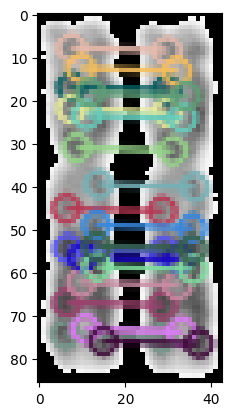

68.96551724137932

In [8]:
# 不翻转
sim1, sim1_keys1, sim1_keys2, sim1_good = sift_similarity_on_roi_ex(img1_bbox, img2_bbox)
sim1_img = cv2.drawMatchesKnn(img1_bbox, sim1_keys1, img2_bbox, sim1_keys2, sim1_good, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(sim1_img)
plt.show()
cv_imwrite("check_feature_point_match01.png", sim1_img)
sim1

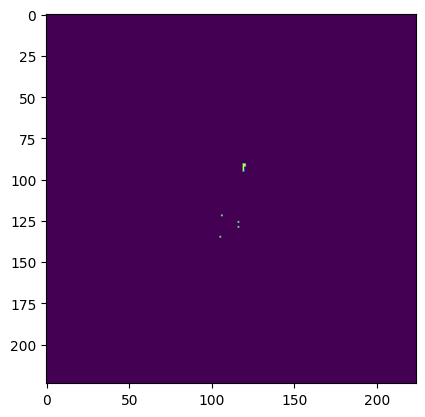

30.0

In [10]:
# 计算差异
difference = cv2.absdiff(img1, img2)

# 将差异转换为灰度图像
gray_difference = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)

# 你可以设定一个阈值来查看显著的差异
diff, threshold_image = cv2.threshold(gray_difference, 30, 255, cv2.THRESH_BINARY)

plt.imshow(threshold_image)
plt.show()
cv_imwrite("check_feature_point_match01_threshold_image.png", threshold_image)
diff

In [17]:
from skimage.metrics import structural_similarity as ssim

# 计算 SSIM
# 确保图像至少是 7x7 像素，或者选择一个小于你图像尺寸的奇数作为 win_size
win_size = min(7, min(img1.shape[0], img1.shape[1], img2.shape[0], img2.shape[1]) - 1) | 1  # 确保是奇数
# 计算 SSIM
similarity_index, sim_x = ssim(img1, img2, win_size=win_size, full=True)

similarity_index, sim_x

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.